In [31]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import sys
sys.path.append("/content/drive/MyDrive/Thesis/reimp_lore")

import os
os.chdir('/content/drive/MyDrive/Thesis/reimp_lore')

# Now the directory '?' is the current working directory.

# Libraries

In [33]:
!pip install symspellpy

In [34]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import pickle
import string
punct = string.punctuation
trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
whitelist = ['?', '!']

import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import re
import pandas as pd
from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
from keras.models import load_model

import json
import matplotlib.pyplot as plt

In [36]:
import nltk
import numpy as np
import random
import pickle

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import re, string
punct = string.punctuation
trantab = str.maketrans(punct, len(punct) * ' ')  # Every punctuation symbol will be replaced by a space
whitelist = ['?', '!']

# Using symspell to correct spelling
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy",
                                                  "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy",
                                              "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [37]:
!pip install bitarray
!pip install scikit-multilearn
!pip install arff

In [38]:
import lore
from datamanager import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score

from util import record2str

In [39]:
np.version.version

'1.19.5'

# Explainer Dataset

In [40]:
## Iris Dataset
# dataset_name = 'dataset/iris.csv'
# dataset = prepare_iris_dataset(dataset_name)

## wine
# dataset_name = 'dataset/wine.csv'
# dataset = prepare_wine_dataset(dataset_name)

##############################################
#           Categorical dataset              #
##############################################
## german: (0 = Good, 1 = Bad)
# dataset_name = 'dataset/german_credit.csv'
# dataset = prepare_german_dataset(dataset_name)

## adult: ['<=50K', '>50K']
# dataset_name = 'dataset/adult.csv'
# dataset = prepare_adult_dataset(dataset_name)

## compas-scores-two-years: ['High', 'Low', 'Medium']
dataset_name = 'dataset/compas-scores-two-years.csv'
dataset = prepare_compass_dataset(dataset_name)

dataframe = dataset[0]
class_name = dataset[1]
dataset_fin = prepare_dataset(dataframe, class_name)

In [41]:
df = dataset_fin[0] #dataframe with unique numeric class values(0, 1, ...)
feature_names = dataset_fin[1]
class_values = dataset_fin[2]
numeric_columns = dataset_fin[3]
rdf = dataset_fin[4] #real dataframe
real_feature_names = dataset_fin[5]
features_map = dataset_fin[6] #map each class name to its unique numeric value
df_categorical_idx = dataset_fin[7]

# Black box classifier

In [42]:
X = df.loc[:, df.columns != class_name].values
y = df[class_name].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
blackbox = RandomForestClassifier()
blackbox.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
y_pred = blackbox.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.597


## Select an instance

In [44]:
i = 10
x = X_test[i]
y_val = blackbox.predict(x.reshape(1,-1))[0]

print(class_values)
class_prob = blackbox.predict_proba(x.reshape(1,-1))[0]
print(class_prob)

y_val_name = class_values[y_val]
print('blackbox(x) = { %s }' % y_val_name)


['High', 'Low', 'Medium']
[0.04 0.95 0.01]
blackbox(x) = { Low }


In [45]:
print('x = %s' % record2str(x, feature_names, numeric_columns))

x = { age = 30, priors_count = 1, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 1, age_cat = 25 - 45, sex = Male, race = Other, c_charge_degree = F }


# LORE explainer (explaining an instance x)

In [83]:
explainer_obj = lore.LORE(X_test, blackbox, feature_names, class_name, class_values,
                 numeric_columns, features_map, df_categorical_idx, neigh_type='ngmusx', verbose=False)

In [47]:
explanation = explainer_obj.explain_instance(x, samples=1000, nbr_runs=10, exemplar_num=3)
print(explanation)

r = { age > 29.84 } --> { class: Low }

feature importance = {'age': 0.6447061138776269}

c =  }

exemplars = { age = 30, priors_count = 0, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 1, age_cat = 25 - 45, sex = Male, race = Other, c_charge_degree = F }
{ age = 30, priors_count = 2, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 1, age_cat = 25 - 45, sex = Male, race = Other, c_charge_degree = F }
{ age = 30, priors_count = 0, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 1, age_cat = 25 - 45, sex = Male, race = Other, c_charge_degree = F }

counter-exemplars = { age = 29, priors_count = 0, days_b_screening_arrest = 1, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 1, age_cat = 25 - 45, sex = Male, race = Other, c_charge_degree = F }
{ age = 29, priors_count = 2, days_b_screening_arrest = 1, is

# X-Bot Model

In [48]:
class XBotModel(object):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def decontractions(self, phrase):
        """decontracted takes text and convert contractions into natural form.
         ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"won\’t", "will not", phrase)
        phrase = re.sub(r"can\’t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)

        phrase = re.sub(r"n\’t", " not", phrase)
        phrase = re.sub(r"\’re", " are", phrase)
        phrase = re.sub(r"\’s", " is", phrase)
        phrase = re.sub(r"\’d", " would", phrase)
        phrase = re.sub(r"\’ll", " will", phrase)
        phrase = re.sub(r"\’t", " not", phrase)
        phrase = re.sub(r"\’ve", " have", phrase)
        phrase = re.sub(r"\’m", " am", phrase)

        return phrase

    def clean_text(self, text):
        # Lower casting
        text = text.lower()
        # Decontracted
        text = self.decontractions(text)
        # Remove more than 1 space
        text = " ".join(text.split())
        # Remove punctuation
        text = text.translate(trantab)
        text_words = nltk.word_tokenize(text)
        words = [lemmatizer.lemmatize(w) for w in text_words if w not in whitelist]
        return words

    def detokenize(self, text):
        return TreebankWordDetokenizer().detokenize(text)


    def prepare_train_dataset(self, data):
        classes = []
        pattern_list = []
        pattern_class = []

        # adding classes to our class list
        # pattern_class = [intent['tag'] for intent in data['intents'] if intent not in pattern_class]

        for intent in data['intents']:
            for pattern in intent['patterns']:

                # clean the pattern
                w = self.clean_text(pattern)

                # adding documents
                detokenize_words = self.detokenize(w)
                pattern_list.append((detokenize_words))
                pattern_class.append(intent['tag'])



        # This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(pattern_list)
        # Transforms each text in texts to a sequence of integers.
        tokenized_seq = tokenizer.texts_to_sequences(pattern_list)

        # Determining the maximum length of the tokenized sequential
        max_length = max([len(s) for s in tokenized_seq])

        # pad_sequences is used to ensure that all sequences in a list have the same length
        padded_sentences = pad_sequences(tokenized_seq, maxlen=max_length, padding='post')
        data_pattern = list(padded_sentences)

        # labels (classes)
        labels = pd.get_dummies(pattern_class).values.tolist()

        # training dataset
        training_dataset = [[a]+[b] for a, b in zip(data_pattern, labels)]

        # shuffle our features and turn into np.array
        random.shuffle(training_dataset)
        training_dataset = np.array(training_dataset)

        # define vocabulary size (largest integer value)
        # The vocabulary size is the total number of words in our vocabulary, plus one for unknown words
        vocab_size = len(tokenizer.word_index) + 1

        # Using pre-trained word embeddings
        embeddings_index = {}
        f = open('glove.6B.100d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        if self.verbose:
          print('Loaded %s word vectors.' % len(embeddings_index))

        # create a weight matrix for words in training docs
        embedding_matrix = np.zeros((vocab_size, 100))
        for word, i in tokenizer.word_index.items():
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

        # a list of different types of intents of responses
        classes = sorted(list(set(pattern_class)))
        # save as a pickle
        pickle.dump(classes, open('classes.pkl', 'wb'))


        if self.verbose:
            print("Training Data Created!")
            print("Words : {}".format(tokenizer.word_index))
            print('Number of  Words = {}'.format(vocab_size))
            print('Maximum Length of Words in a Sentence = {}'.format(max_length))

        return training_dataset, vocab_size, tokenizer, embedding_matrix


    def create_model(self, train_x, train_y, embedding_matrix, vocab_size=1000, embedding_dim=128, lstm_out=100, dropout=0.5):
        input_length = len(train_x[0])
        num_classes = len(train_y[0])

        # Model
        model = Sequential()
        # The embedding layer
        model.add(layers.Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   weights=[embedding_matrix],
                                   input_length=input_length,
                                   trainable=False))
        # The Bidirectional LSTM layer
        model.add(layers.Bidirectional(layers.LSTM(lstm_out,
                                                   dropout=dropout)))
        # The Dense layer
        model.add(layers.Dense(num_classes,
                               activation='softmax'))

        if self.verbose:
            print(model.summary())

        return model

    def compile_fit_model(self, model, train_x, train_y, epochs=100, batch_size=5,
                          earlystopping_patience=10, validation_split=0.3, loss='categorical_crossentropy'):

        if self.verbose:
            verb = 1
        else:
            verb = 0

        es = EarlyStopping(monitor='loss', patience=earlystopping_patience, verbose=verb)
        mc = ModelCheckpoint('best_xbot_model.h5', monitor='val_accuracy', save_best_only=True)

        # Model compilation
        model.compile(loss=loss,
                      optimizer='adam',
                      metrics=['accuracy'])

        # Model Training and Validation
        mymodel = model.fit(x=np.array(train_x),
                            y=np.array(train_y),
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=verb,
                            callbacks=[es, mc]).history
        return mymodel

# Run

In [49]:
###################### Chat Data ######################
data_file = open('chatdata/intents.json').read()
data = json.loads(data_file)

In [50]:
XBot_obj = XBotModel(verbose=True)

# training dataset
train_dataset, vocab_size, tokenizer, embedding_matrix = XBot_obj.prepare_train_dataset(data)
train_x = list(train_dataset[:, 0])
train_y = list(train_dataset[:, 1])

Loaded 400000 word vectors.
Training Data Created!
Words : {'the': 1, 'this': 2, 'instance': 3, 'is': 4, 'how': 5, 'what': 6, 'prediction': 7, 'to': 8, 'feature': 9, 'me': 10, 'you': 11, 'system': 12, 'are': 13, 'doe': 14, 'a': 15, 'exemplar': 16, 'similar': 17, 'give': 18, 'for': 19, 'of': 20, 'why': 21, 'different': 22, 'not': 23, 'thanks': 24, 'that': 25, 'help': 26, 'be': 27, 'performance': 28, 'about': 29, 'make': 30, 'likely': 31, 'rule': 32, 'it': 33, 'explanation': 34, 'explain': 35, 'given': 36, 'counter': 37, 'get': 38, 'top': 39, 'importance': 40, 'important': 41, 'hi': 42, 'there': 43, 'good': 44, 'bye': 45, 'helpful': 46, 'can': 47, 'do': 48, 'accuracy': 49, 'mistake': 50, 'in': 51, 'situation': 52, 'kind': 53, 'factual': 54, 's': 55, 'should': 56, 'change': 57, 'used': 58, 'variable': 59, 'an': 60, 'ciao': 61, 'buongiorno': 62, 'anyone': 63, 'hey': 64, 'hola': 65, 'hello': 66, 'day': 67, 'see': 68, 'later': 69, 'goodbye': 70, 'nice': 71, 'chatting': 72, 'till': 73, 'next'

In [51]:
len(embedding_matrix)

113

In [52]:
# create model
model = XBot_obj.create_model(train_x, train_y, embedding_matrix, vocab_size,
                              embedding_dim=100, lstm_out=15, dropout=0.5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 100)           11300     
_________________________________________________________________
bidirectional (Bidirectional (None, 30)                13920     
_________________________________________________________________
dense (Dense)                (None, 10)                310       
Total params: 25,530
Trainable params: 14,230
Non-trainable params: 11,300
_________________________________________________________________
None


In [53]:
mymodel = XBot_obj.compile_fit_model(model, train_x, train_y, epochs=200,
                                     batch_size=5,
                                     earlystopping_patience=10,
                                     validation_split=0.3,
                                     loss='categorical_crossentropy')

Epoch 1/200
12/12 [==============================] - 5s 119ms/step - loss: 2.3418 - accuracy: 0.0712 - val_loss: 2.3118 - val_accuracy: 0.0769
Epoch 2/200
12/12 [==============================] - 0s 13ms/step - loss: 2.2812 - accuracy: 0.1774 - val_loss: 2.2634 - val_accuracy: 0.0769
Epoch 3/200
12/12 [==============================] - 0s 14ms/step - loss: 2.2312 - accuracy: 0.3195 - val_loss: 2.2372 - val_accuracy: 0.1154
Epoch 4/200
12/12 [==============================] - 0s 13ms/step - loss: 2.1929 - accuracy: 0.2235 - val_loss: 2.2170 - val_accuracy: 0.1154
Epoch 5/200
12/12 [==============================] - 0s 12ms/step - loss: 2.1297 - accuracy: 0.2649 - val_loss: 2.1990 - val_accuracy: 0.1923
Epoch 6/200
12/12 [==============================] - 0s 13ms/step - loss: 2.0656 - accuracy: 0.2878 - val_loss: 2.1935 - val_accuracy: 0.2308
Epoch 7/200
12/12 [==============================] - 0s 13ms/step - loss: 1.9699 - accuracy: 0.3202 - val_loss: 2.1766 - val_accuracy: 0.3077
Epoch

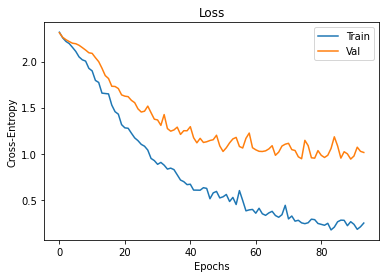

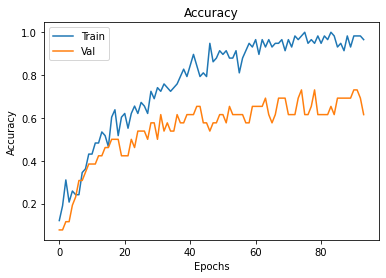

In [54]:
# plot the Train and Validation loss
plt.plot(mymodel['loss'], label='Train')
plt.plot(mymodel['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.title('Loss')
plt.legend()
plt.show()

# plot the Train and Validation accuracy
plt.plot(mymodel['accuracy'], label='Train')
plt.plot(mymodel['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
from keras.models import load_model

trained_model = load_model('best_xbot_model.h5')

_, accuracy = trained_model.evaluate(np.array(train_x), np.array(train_y))
print('Train Accuracy: %.2f' % (accuracy*100))

3/3 [==============================] - 1s 5ms/step - loss: 0.3994 - accuracy: 0.9048
Train Accuracy: 90.48


# Responce Generator

In [125]:
from util import record2str

class ResponseGenerator(object):
    def __init__(self, data, train_x, train_y, tokenizer, model, explainer_data,
                 explainer_prepared_dataset, explainer_obj, blackbox, verbose=False):
        self.data = data
        self.train_x = train_x
        self.train_y = train_y
        self.tokenizer = tokenizer
        self.model = model
        self.explainer_data = explainer_data
        self.explainer_obj = explainer_obj
        self.blackbox = blackbox
        self.verbose = verbose

        self.feature_names = explainer_prepared_dataset[1]
        self.class_values = explainer_prepared_dataset[2]
        self.numeric_columns = explainer_prepared_dataset[3]


        self.classes = pickle.load(open('classes.pkl', 'rb'))

    def decontractions(self, phrase):
        """decontracted takes text and convert contractions into natural form.
         ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"won\’t", "will not", phrase)
        phrase = re.sub(r"can\’t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)

        phrase = re.sub(r"n\’t", " not", phrase)
        phrase = re.sub(r"\’re", " are", phrase)
        phrase = re.sub(r"\’s", " is", phrase)
        phrase = re.sub(r"\’d", " would", phrase)
        phrase = re.sub(r"\’ll", " will", phrase)
        phrase = re.sub(r"\’t", " not", phrase)
        phrase = re.sub(r"\’ve", " have", phrase)
        phrase = re.sub(r"\’m", " am", phrase)

        return phrase

    def clean_text(self, text):
        # Lower casting
        text = text.lower()
        # Decontracted
        text = self.decontractions(text)
        # Remove more than 1 space
        text = " ".join(text.split())
        # Remove punctuation
        text = text.translate(trantab)
        text_words = nltk.word_tokenize(text)
        words = [lemmatizer.lemmatize(w) for w in text_words if w not in whitelist]
        return words

    def correct_spellings(self, text):
        """ For a given sentence this function returns a sentence after correcting
          spelling of words """
        suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
        return suggestions[0]._term

    def detokenize(self, text):
        return TreebankWordDetokenizer().detokenize(text)

    # return bag of words array: 0 or 1 for each word in the bag that exists in the user input
    def texts_to_sequences(self, user_input):
        # correcting spelling of words of user input
        user_input = self.correct_spellings(user_input)
        # tokenize the user input
        user_input_words = self.clean_text(user_input)
        detokenize_words = self.detokenize(user_input_words)


        # Transforms each text in texts to a sequence of integers.
        tokenized_seq = self.tokenizer.texts_to_sequences([detokenize_words])

        # get max length of tokenized sequential from training data
        max_length = len(self.train_x[0])
        # pad_sequences is used to ensure that all sequences in a list have the same length
        padded_sentences = pad_sequences(tokenized_seq, maxlen=max_length, padding='post')
        user_input_seq = np.array(padded_sentences)

        return user_input_seq

    def predict_class(self, user_input):
        return_list = []
        user_input_seq = self.texts_to_sequences(user_input)
        # check if all elements of user input sequential is zero or not
        if np.all((user_input_seq[0] == 0)):
            return_list.append({'intent': 'noanswer', 'probability': '1'})
        else:
            res = self.model.predict(user_input_seq)[0]
            # filter out predictions below a threshold
            ERROR_THRESHOLD = 0.6
            results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

            # sort by strength of probability
            results.sort(key=lambda x: x[1], reverse=True)

            for r in results:
                return_list.append({"intent": self.classes[r[0]], "probability": str(r[1])})
        return return_list

    def get_response(self, ints):
        result = ''
        context = ''
        if not ints:
            tag = 'noanswer'
        else:
            tag = ints[0]['intent']

        list_of_intents = self.data['intents']
        for i in list_of_intents:
            if i['tag'] == tag:
                result = random.choice(i['responses'])
                context = i['context']
                break
        return result, context

    def chatbot_response(self, user_input):
        # predict the intent of the user query
        intents = self.predict_class(user_input)
        # ask for the response
        output_response, context = self.get_response(intents)

        return output_response, context[0]

    def get_explanation(self, context, explanation):
        if context == 'rule':
            exp = explanation.rule
        elif context == 'crule':
            exp = explanation.cstr()
        elif context == 'fidelity':
            exp = explanation.fidelity
        elif context == 'exemplar':
            exp = explanation.exemplars
        elif context == 'cexemplar':
            exp = explanation.cexemplars
        elif context == 'feature_importance':
            exp = explanation.feature_importance
        else:
            exp = "Nothing found!"

        return exp

    def start(self):
        print("Hello, I'm X-Bot!"
              "\n(If you want to exit, type -1!)")
        print("\nX-Bot: The length of the dataset is %s." % len(self.explainer_data))

        flag_exit = False
        flag_explainer = True
        while flag_explainer:
            print('\n')
            print("Select an instance x (enter a row number)")
            user_input = input()
            try:
                i = int(user_input)
            except:
                print("Please enter a valid number!")
                continue
            if i < 0:
                flag_exit = True
                print("See you later!")
                break
            elif i > len(self.explainer_data):
                print("It must be less than the length of the dataset (%s)!" % len(self.explainer_data))
                continue
            else:
                x = self.explainer_data[i]
                y_val_name = self.class_values[self.blackbox.predict(x.reshape(1,-1))[0]]
                print('\nX-Bot: Selected x is -> %s.' % record2str(x, self.feature_names, self.numeric_columns))
                print('Blackbox(x) = { %s }' % y_val_name)
                print('\n')

                print('X-Bot: Do you want me to continue with this instance? [y/n]')
                is_yes = input()
                try:
                  if is_yes == "y":
                      explanation = self.explainer_obj.explain_instance(x, samples=1000,
                                                                        nbr_runs=10, exemplar_num=3)
                      flag_explainer = False
                  else:
                      continue
                except:
                  print("Please enter y or n!")
                  continue


        flag_chat = True
        if not flag_exit:
            print("\n")
            print("X-Bot: Ok! How can I help you?"
                  "\n(If you want to exit, type Bye!)")
        while flag_chat and not flag_exit:
            
            user_input = input()
            if user_input == '':
                print('X-Bot: Please type something!\n')
            else:
                output_response, context = self.chatbot_response(user_input)

                print("X-Bot: %s" % output_response)
                if context != "" and context != "exit":
                    explain = self.get_explanation(context, explanation)
                    print(explain)
                    print('\n')
                elif context == "exit":
                    flag_chat = False
                else:
                    print('\n')

# Start to *chat*

In [126]:
xbot_response = ResponseGenerator(data, train_x, train_y, tokenizer, trained_model,
                                  X, dataset_fin, explainer_obj, blackbox, verbose=True)

In [129]:
xbot_response.start()

Hello, I'm X-Bot!
(If you want to exit, type -1!)

X-Bot: The length of the dataset is 7214.


Select an instance x (enter a row number)
ge
Please enter a valid number!


Select an instance x (enter a row number)
18466
It must be less than the length of the dataset (7214)!


Select an instance x (enter a row number)
142

X-Bot: Selected x is -> { age = 20, priors_count = 1, days_b_screening_arrest = 0, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 2, age_cat = Less than 25, sex = Female, race = African-American, c_charge_degree = F }.
Blackbox(x) = { Medium }


X-Bot: Do you want me to continue with this instance? [y/n]
n


Select an instance x (enter a row number)
562

X-Bot: Selected x is -> { age = 30, priors_count = 0, days_b_screening_arrest = 0, is_recid = 0, is_violent_recid = 0, two_year_recid = 0, length_of_stay = 1, age_cat = 25 - 45, sex = Female, race = African-American, c_charge_degree = M }.
Blackbox(x) = { Low }


X-Bot: Do you want me to conti